<a href="https://colab.research.google.com/github/Nielk74/ia-clothes/blob/master/data/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Présentation

Ce notebook présente une méthode de clustering de couleurs extraites à partir de ce [notebook](https://colab.research.google.com/drive/19Hn6Y-09XlVNDg7Hp798v5ZL41UBsx8S?usp=sharing).

# Setup

In [ ]:
!wget -q https://raw.githubusercontent.com/Nielk74/ia-clothes/master/data/datasets/men.csv -O men.csv
!wget -q https://raw.githubusercontent.com/Nielk74/ia-clothes/master/data/datasets/women.csv -O women.csv

In [ ]:
!pip install numpy
!pip install scikit-learn
!pip install matplotlib
!pip install colour-science


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 14.9 MB/s eta 0:00:00


# Clustering

Import de dépendances

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import colour
from colour.models import RGB_COLOURSPACE_sRGB
import csv

/usr/local/lib/python3.10/dist-packages/colour/utilities/verbose.py:265: ColourWarning: "vaab/colour" was detected in "sys.path", please define a "COLOUR_SCIENCE__COLOUR__IMPORT_VAAB_COLOUR=True" environment variable to import its objects into "colour" namespace!
  warn(*args, **kwargs)  # noqa: B028


Récupération de paramètres

In [ ]:
clothes_cluster_nb = 10 # int(input("Saisissez le nombre de cluster souhaité pour les couleurs de vêtements : "))
nb_cluster_skin = 5 # int(input("Saisissez le nombre de cluster souhaité pour les couleurs de peau : "))

In [ ]:
def colored_background(r, g, b, text):
    r = int(r)
    g = int(g)
    b = int(b)
    return f'\033[48;2;{r};{g};{b}m{text}\033[0m'


def normalize_to_srgb(rgb):
    return np.dot(1/255,rgb)

def get_data_from_input(path):
    dict_skin = {}

    with open(path, 'r' ) as infile:
        reader = csv.reader(infile, delimiter=';')
        for row in reader:
            if 'None' in row[1] or 'None' in row[2] or 'None' in row[3]:
                continue

            skin_column = row[3].strip()
            lower_column = row[2].strip()
            upper_column = row[1].strip()

            rgb_skin = np.array(skin_column.split(',')).astype(np.uint8)
            rgb_upper = np.array(upper_column.split(',')).astype(np.uint8)
            rgb_lower = np.array(lower_column.split(',')).astype(np.uint8)
            dict_skin[str(rgb_skin)] = {'upper':rgb_upper,'lower':rgb_lower, 'skin': rgb_skin, 'path':row[0]}
    return dict_skin

color_space = (RGB_COLOURSPACE_sRGB,)

def clustering(num_clusters, data, is_clothes=False):
    kmeans = KMeans(n_clusters=num_clusters, n_init=num_clusters)

    # lab_data = np.apply_along_axis(normalize_to_srgb, 1, data)
    # lab_data = np.apply_along_axis(colour.RGB_to_XYZ, 1, lab_data, *color_space)
    # lab_data = np.apply_along_axis(colour.XYZ_to_Lab, 1, lab_data)
    if is_clothes:
      lab_data = np.apply_along_axis(rgb_to_lab_clothes, 1, data)
    else:
      lab_data = np.apply_along_axis(rgb_to_lab, 1, data)
    kmeans.fit(lab_data)

    cluster_labels = kmeans.labels_
    cluster_centers = kmeans.cluster_centers_

    return cluster_labels, cluster_centers

def lab_to_rgb(lab):
    lab = np.array(lab)
    lab = np.reshape(lab, (1,3))
    lab = np.apply_along_axis(colour.Lab_to_XYZ, 1, lab)
    lab = np.apply_along_axis(colour.XYZ_to_RGB, 1, lab, *color_space)
    lab = np.apply_along_axis(np.dot, 1, lab, 255)
    return lab[0]

def rgb_to_lab(rgb):
    rgb = normalize_to_srgb(rgb)
    rgb = colour.RGB_to_XYZ(rgb, *color_space)
    rgb = colour.XYZ_to_Lab(rgb)
    return rgb
def rgb_to_lab_clothes(rgb):
    rgb = normalize_to_srgb(rgb)
    rgb = colour.RGB_to_XYZ(rgb, *color_space)
    rgb = colour.XYZ_to_Lab(rgb)
    if rgb[0] < 45 or rgb[0] > 90:
      rgb[1] = 0
      rgb[2] = 0
    if rgb[0] < 45:
      rgb[0] = 40
    if rgb[0] > 90:
      rgb[0] = 95
    return rgb
dict_skin = get_data_from_input('women.csv')

skin_data = []
upper_data =[]
lower_data = []

nb_cluster_upper = clothes_cluster_nb
nb_cluster_lower = clothes_cluster_nb

for data in dict_skin.items():
    skin_data.append(data[1]['skin'])
    upper_data.append(data[1]['upper'])
    lower_data.append(data[1]['lower'])

skin_data = np.array(skin_data)
upper_data = np.array(upper_data)
lower_data = np.array(lower_data)

cluster_labels_skin, cluster_centers_skin = clustering(nb_cluster_skin, skin_data)
cluster_labels_upper, cluster_centers_upper = clustering(nb_cluster_upper, upper_data)
cluster_labels_lower, cluster_centers_lower = clustering(nb_cluster_lower, lower_data)



In [ ]:
print("Clusters de peau:")
for i in range(nb_cluster_skin):
    # plot as a hsv color
    lab = cluster_centers_skin[i]
    rgb = lab_to_rgb([lab[0], lab[1], lab[2]])
    print(colored_background(rgb[0],rgb[1],rgb[2], 'skin : '+str(i)),lab)
print("\nClusters de haut:")
for i in range(clothes_cluster_nb):
    # plot as a hsv color
    lab = cluster_centers_upper[i]
    rgb = lab_to_rgb([lab[0], lab[1], lab[2]])
    print(colored_background(rgb[0],rgb[1],rgb[2], 'upper : '+str(i)), lab)

print("\nClusters de bas:")
for i in range(clothes_cluster_nb):
    # plot as a hsv color
    lab = cluster_centers_lower[i]
    rgb = lab_to_rgb([lab[0], lab[1], lab[2]])
    print(colored_background(rgb[0],rgb[1],rgb[2], 'lower : '+str(i)), lab)


Clusters de peau:
skin : 0 [ 89.80776098   4.65824193  13.06126487]
skin : 1 [ 71.68231378  10.27650941  16.37697519]
skin : 2 [ 93.3963141    2.77280508   6.82335534]
skin : 3 [ 82.47864533   7.38477851  14.19883889]
skin : 4 [ 87.74699911   5.39122618   9.01683408]

Clusters de haut:
upper : 0 [ 76.47931247   0.72956529  -0.317362  ]
upper : 1 [ 49.45332917   2.2754041   -1.92099907]
upper : 2 [ 56.92330779  62.78303993   3.6543473 ]
upper : 3 [ 85.71628165  -0.78950543  37.10731719]
upper : 4 [ 95.69057207   0.4482556    0.62575879]
upper : 5 [ 77.60234567  22.74718963  11.88651056]
upper : 6 [ 71.29745284 -28.90238163 -18.87325361]
upper : 7 [ 54.66864324   4.3924783  -23.71359428]
upper : 8 [ 37.65157281   1.68252116   0.86894185]
upper : 9 [ 53.15559209  33.46408908   8.12652291]

Clusters de bas:
lower : 0 [ 41.86260463   1.51252218   0.11774671]
lower : 1 [ 86.05821321  -1.49728005  -4.45351039]
lower : 2 [  9.61506536e+01  -5.36022095e-02  -1.62192642e-01]
lower : 3 [ 55.34430

# Matrice d'occurences par couleur

In [ ]:

occurences = {}

for data in dict_skin.items():
    skin = data[1]['skin']
    upper = data[1]['upper']
    lower = data[1]['lower']
    path = data[1]['path']

    skin_cluster = cluster_labels_skin[np.where((skin_data == skin).all(axis=1))][0]
    upper_cluster = cluster_labels_upper[np.where((upper_data == upper).all(axis=1))][0]
    lower_cluster = cluster_labels_lower[np.where((lower_data == lower).all(axis=1))][0]

    rgb_upper = lab_to_rgb(cluster_centers_upper[upper_cluster])
    rgb_lower = lab_to_rgb(cluster_centers_lower[lower_cluster])
    diff_upper = abs(rgb_upper[0] - rgb_upper[1]) + abs(rgb_upper[1] - rgb_upper[2]) + abs(rgb_upper[0] - rgb_upper[2])
    diff_lower = abs(rgb_lower[0] - rgb_lower[1]) + abs(rgb_lower[1] - rgb_lower[2]) + abs(rgb_lower[0] - rgb_lower[2])
    key = str(skin_cluster) + ',' + str(upper_cluster) + ',' + str(lower_cluster)

    if key in occurences:
        occurences[key]['occurences'] += 1
    else:
        occurences[key] = {'skin_cluster': skin_cluster, 'upper_cluster': upper_cluster, 'lower_cluster': lower_cluster, 'occurences': 1, 'path': path}


# Extraction des objets de clusters sous format json

In [ ]:
import json
import numpy
def convert(o):
    if isinstance(o, numpy.int32): return int(o)
    elif isinstance(o, numpy.ndarray): return o.tolist()
    raise TypeError


with open('woccurences.json', 'w') as fp:
  json.dump(occurences, fp, default=convert)

clusters_json = {"cluster_centers_skin":cluster_centers_skin,
                 "cluster_centers_upper":cluster_centers_upper,
                 "cluster_centers_lower":cluster_centers_lower}
with open('wclusters.json', 'w') as fp:
  json.dump(clusters_json, fp, default=convert)

#cluster_centers_skin
#cluster_centers_upper
#cluster_centers_lower

# Récupération de la teinte de couleur de peau d'une image

In [ ]:
!pip install transformers
!pip install torch
!pip install extcolors

In [ ]:
from transformers import SegformerImageProcessor, AutoModelForSemanticSegmentation
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torch.nn as nn
import os
import extcolors
import numpy as np
import tensorflow as tf
import cv2
from google.colab.patches import cv2_imshow
from sklearn.cluster import KMeans
import torch

processor = SegformerImageProcessor.from_pretrained("mattmdjaga/segformer_b2_clothes")
model = AutoModelForSemanticSegmentation.from_pretrained("mattmdjaga/segformer_b2_clothes")
device = "cuda:0" if torch.cuda.is_available() else "cpu"
model.to(device)
print()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/segformer/image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

In [ ]:
def get_clothes_and_skin_colors(image):
  # Load model
  inputs = processor(images=image, return_tensors="pt").to(device)
  outputs = model(**inputs)
  logits = outputs.logits.cpu()

  upsampled_logits = nn.functional.interpolate(
      logits,
      size=image.size[::-1],
      mode="bilinear",
      align_corners=False,
  )

  # Get the segmentation prediction
  pred_seg = upsampled_logits.argmax(dim=1)[0]

  rows, cols = pred_seg.shape
  upper_mask = np.full((rows, cols), False, dtype=bool)
  lower_mask = np.full((rows,cols), False, dtype=bool)
  skin_mask = np.full((rows,cols), False, dtype=bool)
  dress_mask = np.full((rows,cols), False, dtype=bool)
  has_upper = False
  has_lower = False
  has_skin = False
  has_dress = False
  # Iterate through the 2D tensor array with indices

  # Convert pytorch tensor to numpy array to optimize
  segmentation = pred_seg.detach().cpu().numpy()

  for i in range(rows):
      for j in range(cols):
        v = segmentation[i, j]
        if v == 4: # upper clothes
          upper_mask[i, j] = True
          has_upper = True
        elif v == 6 or v == 5: # pants or skirt
          lower_mask[i, j] = True
          has_lower = True
        elif v in [11, 12, 13, 14, 15]: #body parts
          skin_mask[i, j]=  True
          has_skin = True
        elif v == 7: # dress:
          dress_mask[i, j] =  True
          has_dress = True


  if not has_skin:
    return None
  if has_dress:
    dress_color = getColorDominantFromMask(image, dress_mask)
    return (dress_color, dress_color,getColorDominantFromMask(image, skin_mask))
  elif not has_upper or not has_lower:
    return None
  else:
    return (getColorDominantFromMask(image, upper_mask), getColorDominantFromMask(image, lower_mask), getColorDominantFromMask(image, skin_mask))


def getColorDominantFromMask(image, mask):
  # apply mask
  binary_mask = (mask * 255).astype(np.uint8)

  # convert PIL image to openCV image
  imageCV = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGRA)

  # add the forth dimension (opacity)
  four_channel_mask = cv2.merge([binary_mask] * 4)

  # Apply mask
  result = cv2.bitwise_and(imageCV, four_channel_mask)

  # Convert to PIL image
  pil_image = Image.fromarray(cv2.cvtColor(result, cv2.COLOR_BGR2RGBA))

  # get dominant color
  colors, pixel_count = extcolors.extract_from_image(pil_image)
  return colors[0][0]
def get_skin_color(image):


  inputs = processor(images=image, return_tensors="pt").to(device)
  outputs = model(**inputs)
  logits = outputs.logits.cpu()

  upsampled_logits = nn.functional.interpolate(
      logits,
      size=image.size[::-1],
      mode="bilinear",
      align_corners=False,
  )

  # Get the segmentation prediction
  pred_seg = upsampled_logits.argmax(dim=1)[0]
  rows, cols = pred_seg.shape

  skin_mask = np.full((rows,cols), False, dtype=bool)
  segmentation = pred_seg.detach().cpu().numpy()
  has_skin = False

  for i in range(rows):
      for j in range(cols):
        v = segmentation[i, j]
        if v in [11,12,13,14,15]: #body parts (11 face, 12 left leg, 13 right leg, arms...)
          skin_mask[i,j]=  True
          has_skin = True

  return getColorDominantFromMask(image,skin_mask)

Saving IMG_7244 (1).jpg to IMG_7244 (1).jpg
skin_color 

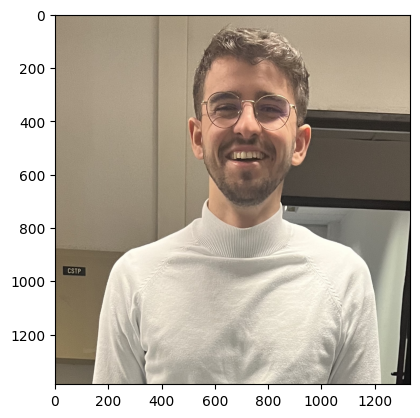

In [ ]:
from google.colab import files
src = list(files.upload().values())[0] # upload image
open('uploaded_image.jpg','wb').write(src)
image= Image.open('uploaded_image.jpg')
plt.imshow(image)
skin_color = get_skin_color(image)
print(colored_background(int(skin_color[0]), int(skin_color[1]), int(skin_color[2]), "skin_color"), end=' ')

In [ ]:
rgb_input = normalize_to_srgb(skin_color)
lab_input = colour.RGB_to_XYZ(rgb_input, *color_space)
lab_input = colour.XYZ_to_Lab(lab_input)
# find the closest skin cluster
closest_skin_cluster = 0
closest_skin_cluster_distance = 10000
for skin_cluster in range(nb_cluster_skin):
    lab_skin_cluster = cluster_centers_skin[skin_cluster]
    distance = np.linalg.norm(lab_input - lab_skin_cluster)
    if distance < closest_skin_cluster_distance:
        closest_skin_cluster_distance = distance
        closest_skin_cluster = skin_cluster

rgb_closest_skin_cluster = lab_to_rgb(cluster_centers_skin[closest_skin_cluster])
print(colored_background(int(rgb_closest_skin_cluster[0]), int(rgb_closest_skin_cluster[1]), int(rgb_closest_skin_cluster[2]), 'closest skin cluster number ' + str(closest_skin_cluster)), end=' ')

closest skin cluster number 0 

# Récupération des occurences pour la teinte de peau de l'image

In [ ]:
def get_occurences_by_skin_cluster(skin_cluster, occurences):
    occurences_by_skin_cluster = {}
    for key, value in occurences.items():
        if value['skin_cluster'] == skin_cluster:
            occurences_by_skin_cluster[key] = value
    occurences_by_skin_cluster = {k: v for k, v in sorted(occurences_by_skin_cluster.items(), key=lambda item: item[1]['occurences'], reverse=True)}
    return occurences_by_skin_cluster


def get_closest_cluster(lab_color, clusters):
    closest_cluster = 0
    closest_cluster_distance = 10000000
    for center_cluster in range(len(clusters)):
        lab_cluster = clusters[center_cluster]
        distance = np.linalg.norm(lab_color - lab_cluster)
        if distance < closest_cluster_distance:
            closest_cluster_distance = distance
            closest_cluster = center_cluster
    return closest_cluster


# for i in range(10):
#     key = list(occurences_by_skin_cluster.keys())[i]
#     value = occurences_by_skin_cluster[key]
#     rgb_upper = lab_to_rgb(cluster_centers_upper[value['upper_cluster']])
#     rgb_lower = lab_to_rgb(cluster_centers_lower[value['lower_cluster']])
#     print("Occurences : " + str(value['occurences']), end=' ')
#     print(colored_background(int(rgb_upper[0]), int(rgb_upper[1]), int(rgb_upper[2]), f'Upper {value["upper_cluster"]}'), end=' ')
#     print(colored_background(int(rgb_lower[0]), int(rgb_lower[1]), int(rgb_lower[2]), f'Lower {value["lower_cluster"]}'), end=' ')
#     print("Exemple d'image : " + value['path'])
#     print("\n")

Pas de score


# Calcul de score

In [ ]:
def get_max_occ(cluster):
  max_key=max(cluster, key=lambda k: cluster[k]['occurences'])
  return cluster[max_key]['occurences']


def score(occurences, upper_clusters, lower_clusters, skin_clusters, image_input,closest_skin_cluster):
    occurences_by_skin_cluster = get_occurences_by_skin_cluster(closest_skin_cluster, occurences)
    max_occ = get_max_occ(occurences_by_skin_cluster)
    colors_set = get_clothes_and_skin_colors(image_input)

    # if there is an undetected color, we dont give a score
    if colors_set == None or not all(colors_set):
      return None
    upper_color, lower_color, skin_color = colors_set
    upper_lab, lower_lab, skin_lab = rgb_to_lab(upper_color), rgb_to_lab(lower_color), rgb_to_lab(skin_color)
    closest_upper_cluster, closest_lower_cluster,closest_skin_cluster = get_closest_cluster(upper_lab, upper_clusters), get_closest_cluster(lower_lab, lower_clusters), get_closest_cluster(skin_lab, skin_clusters)
    key = str(closest_skin_cluster) + ',' + str(closest_upper_cluster) +',' +str(closest_lower_cluster)
    if key in occurences:
        return (occurences[key]['occurences']/max_occ) *30 + 70
    else:
        return None


s = score(occurences,cluster_centers_upper,cluster_centers_lower,cluster_centers_skin,image,closest_skin_cluster)
if s == None:
  print("Pas de score")
else:
  print("Score:" + str(s))
